## Когда цена сильно падает (RSI становится очень низким), стратегия покупает, ожидая отскок цены обратно вверх
### Логика входов (покупки)
Стратегия делает 3 поэтапных входа при падении RSI:
* 1-й вход: RSI ≤ 40-50 (размер позиции 20% капитала)
* 2-й вход: RSI ≤ 25-35 (размер позиции 30% капитала)
* 3-й вход: RSI ≤ 20-30 (размер позиции 50% капитала)

### Расчет размера позиции
* Размер позиции = (% капитала × общий капитал × плечо) / цена, где плечо = 5x

### Выходы (продажа)
Закрытие всей позиции при любом из условий:
* RSI ≥ 60 (цель достигнута)
* Убыток ≥ 2% (стоп-лосс)

### Расчет P&L
* P&L = (цена_выхода - средняя_цена_входа) × общий_размер_позиции
* P&L_на_капитал = P&L / плечо

### Ключевые особенности
* Усреднение вниз: чем больше падает цена, тем больше покупаем
* Лимитные ордера: покупка точно на заданных уровнях RSI
* Плечо 5x: увеличивает как прибыль, так и риски
* Фиксированный стоп-лосс: защита от больших потерь

Загружаем данные BTCUSDT с 2024-01-01 по 2024-12-31...
Загружено 8761 свечей

АНАЛИЗ СТАЦИОНАРНОСТИ

=== Тест Дики-Фуллера для Цена BTCUSDT ===
ADF Statistic: -1.027368
p-value: 0.743152
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Результат: Цена BTCUSDT НЕ является стационарным (не отвергаем H0)

=== Тест Дики-Фуллера для RSI ===
ADF Statistic: -17.556988
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Результат: RSI является стационарным (отвергаем H0)

=== Тест Дики-Фуллера для Логарифмические доходности ===
ADF Statistic: -94.903494
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Результат: Логарифмические доходности является стационарным (отвергаем H0)

ОПТИМИЗАЦИЯ ПАРАМЕТРОВ


Тестирование параметров: 100%|███████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]



Лучшие параметры:
RSI Period: 14
Entry Levels: [50, 45, 35, 20]
Profit Factor: 1.24

РЕЗУЛЬТАТЫ ЛУЧШЕЙ СТРАТЕГИИ
Общее количество сделок: 246
Процент прибыльных сделок: 67.1%
Коэффициент прибыли: 1.24
Общая доходность: 48.5%
Максимальная просадка: -17.2%
Коэффициент Шарпа: 1.56
Средняя прибыльная сделка: $151.85
Средняя убыточная сделка: $249.41


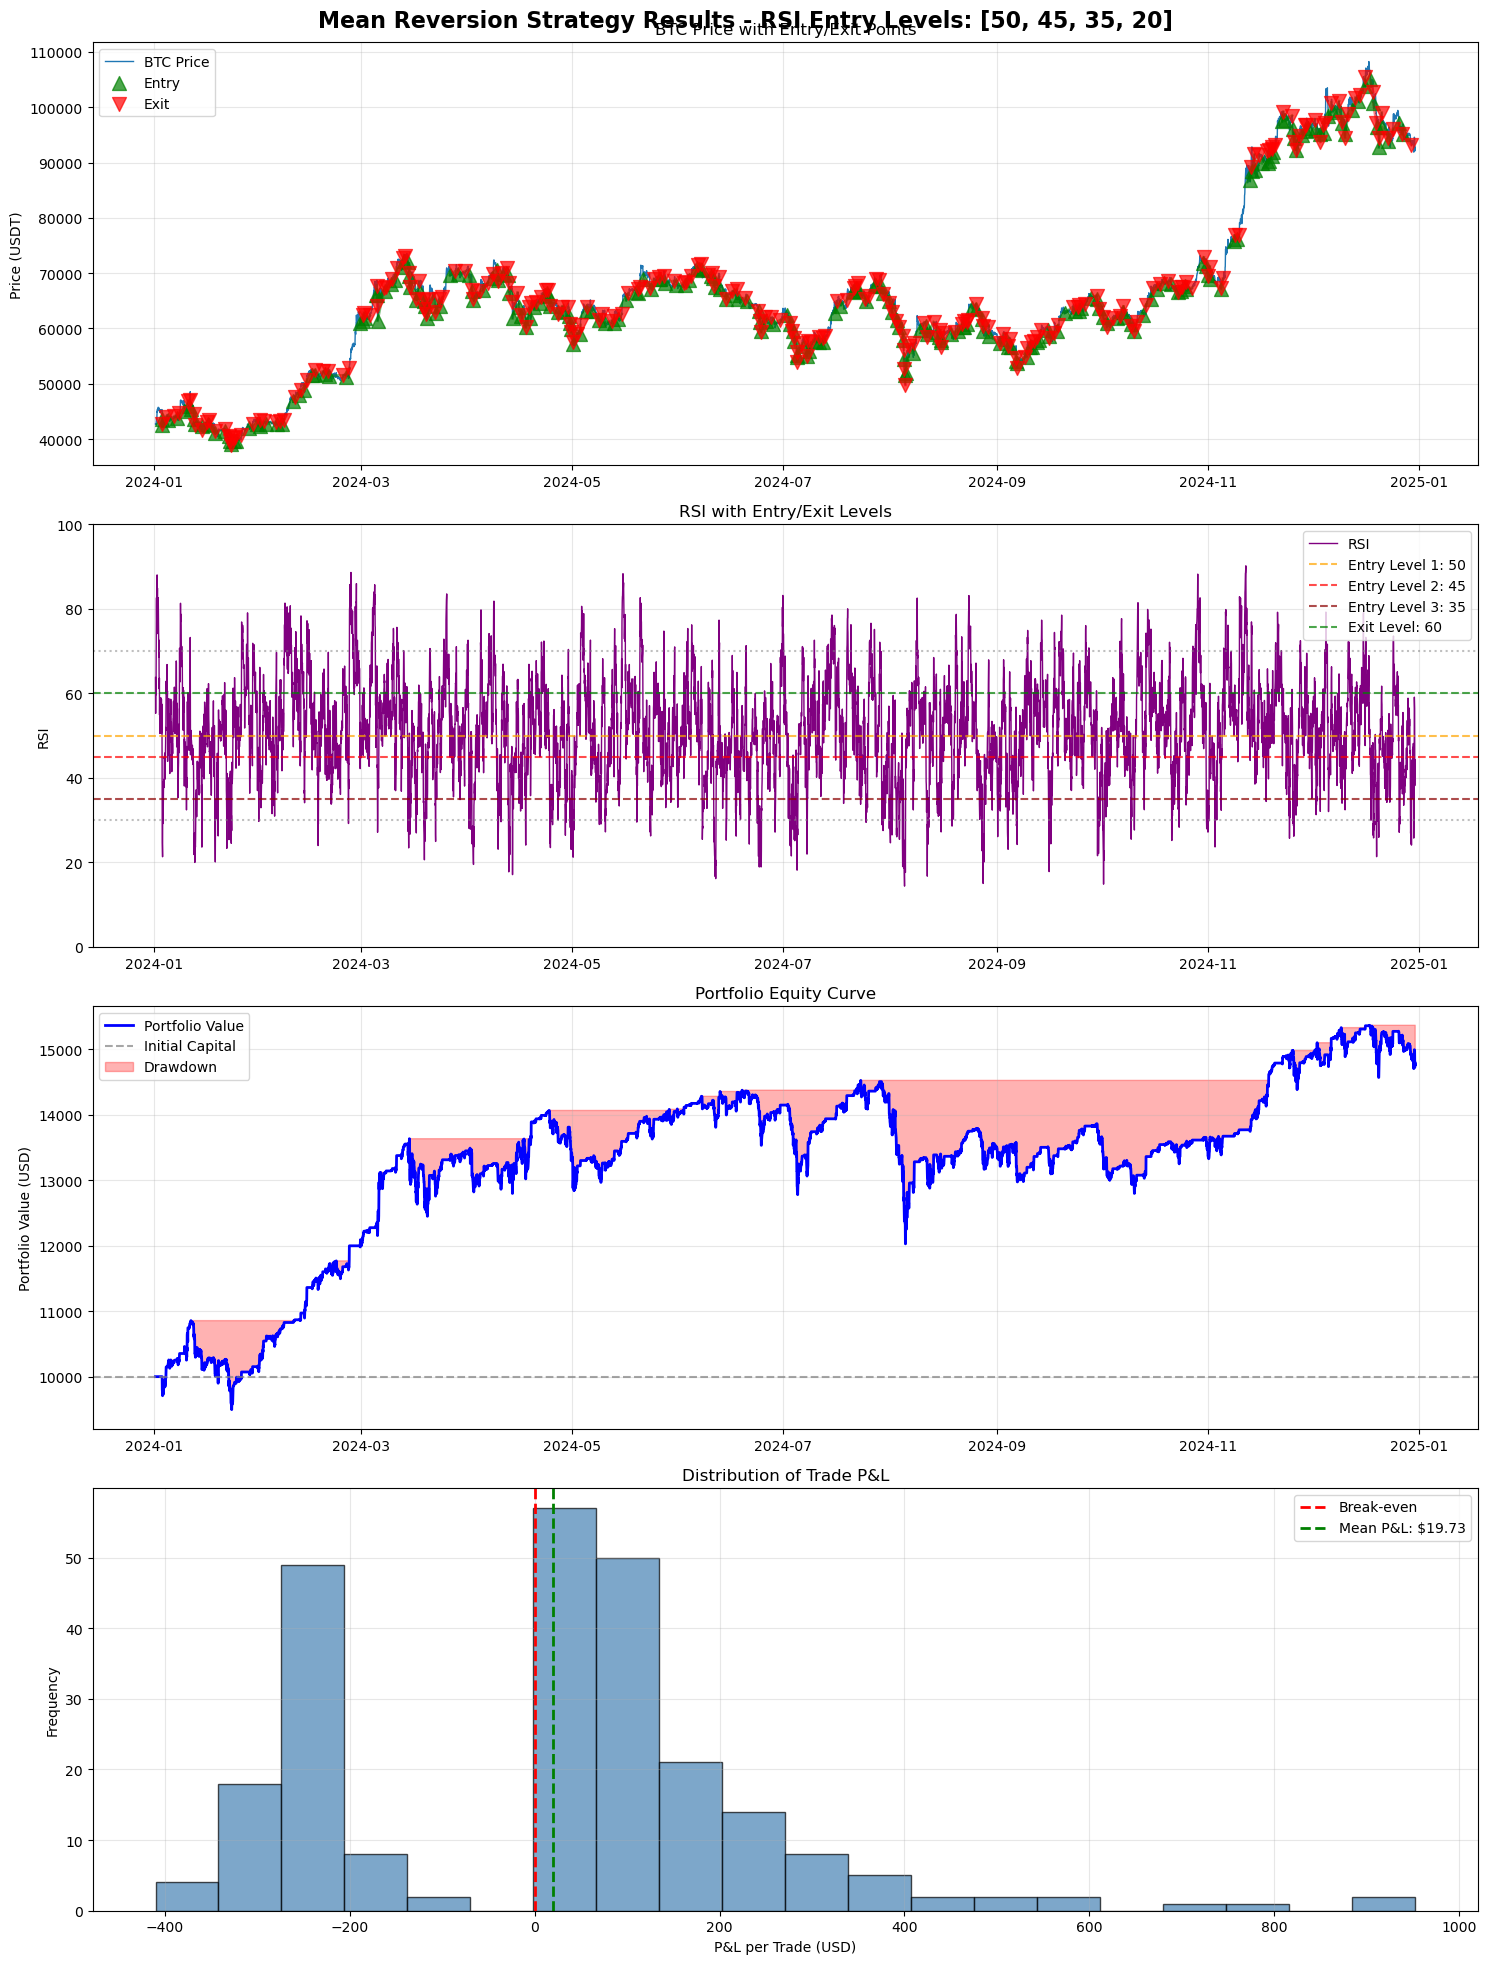


СРАВНЕНИЕ ВСЕХ ПРОТЕСТИРОВАННЫХ ПАРАМЕТРОВ
    Entry Levels  Total Trades Win Rate Profit Factor Total Return Max Drawdown Sharpe Ratio
[50, 45, 35, 20]           246    67.1%          1.24        48.5%       -17.2%         1.56
    [35, 25, 20]           114    54.4%          1.14         9.9%       -12.9%         0.63
[45, 40, 30, 20]           194    61.3%          1.10        18.1%       -18.6%         0.75
    [42, 32, 27]           167    60.5%          0.98        -2.8%       -23.1%         0.01
    [38, 28, 23]           133    59.4%          0.94        -5.5%       -16.6%        -0.20


In [5]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
import ta

warnings.filterwarnings('ignore')

# =============================================================================
# ПАРАМЕТРЫ СТРАТЕГИИ
# =============================================================================

# Основные параметры
SYMBOL = 'BTCUSDT'
INTERVAL = '1h'
START_DATE = '2024-01-01'
END_DATE = '2024-12-31'
INITIAL_CAPITAL = 10000
LEVERAGE = 10
TRADING_CAPITAL = INITIAL_CAPITAL * LEVERAGE

# Параметры позиций
POSITION_SIZES = [0.3, 0.3, 0.4]  # 20%, 30%, 50% от капитала
STOP_LOSS_PCT = -0.02  # -2% стоп-лосс
EXIT_RSI = 60

# Параметры для оптимизации (будем тестировать разные уровни RSI)
RSI_PERIODS = [14]  # Период RSI
RSI_ENTRY_LEVELS = [
    [45, 40, 30, 20],  # Базовые уровни
    [50, 45, 35, 20],  # Более консервативные
    [35, 25, 20],  # Более агрессивные
    [42, 32, 27],  # Альтернативные
    [38, 28, 23],  # Более глубокие уровни
]

# =============================================================================
# ФУНКЦИИ ДЛЯ ПОЛУЧЕНИЯ ДАННЫХ
# =============================================================================

def get_binance_data(symbol, interval, start_date, end_date):
    """Получение данных с API Binance"""
    
    # Конвертируем даты в timestamp
    start_ts = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_ts = int(pd.Timestamp(end_date).timestamp() * 1000)
    
    # URL для API Binance
    url = 'https://api.binance.com/api/v3/klines'
    
    all_data = []
    current_start = start_ts
    
    print(f"Загружаем данные {symbol} с {start_date} по {end_date}...")
    
    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1000
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        if not data:
            break
            
        all_data.extend(data)
        current_start = data[-1][6] + 1  # Следующий timestamp
        
        if len(data) < 1000:
            break
    
    # Создаем DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Конвертируем типы данных
    numeric_columns = ['open', 'high', 'low', 'close', 'volume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    return df[['open', 'high', 'low', 'close', 'volume']]

# =============================================================================
# ФУНКЦИИ ДЛЯ АНАЛИЗА СТАЦИОНАРНОСТИ
# =============================================================================

def check_stationarity(series, name):
    """Проверка стационарности временного ряда"""
    result = adfuller(series.dropna())
    
    print(f'\n=== Тест Дики-Фуллера для {name} ===')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"Результат: {name} является стационарным (отвергаем H0)")
        return True
    else:
        print(f"Результат: {name} НЕ является стационарным (не отвергаем H0)")
        return False

# =============================================================================
# ФУНКЦИИ ДЛЯ БЭКТЕСТИРОВАНИЯ
# =============================================================================

class MeanReversionBacktester:
    def __init__(self, data, rsi_period=14, entry_levels=[40, 30, 25], 
                 exit_rsi=60, stop_loss_pct=-0.03, position_sizes=[0.2, 0.3, 0.5],
                 initial_capital=10000, leverage=5):
        
        self.data = data.copy()
        self.rsi_period = rsi_period
        self.entry_levels = sorted(entry_levels, reverse=True)  # [40, 30, 25]
        self.exit_rsi = exit_rsi
        self.stop_loss_pct = stop_loss_pct
        self.position_sizes = position_sizes
        self.initial_capital = initial_capital
        self.leverage = leverage
        self.trading_capital = initial_capital * leverage
        
        # Добавляем RSI
        self.data['rsi'] = ta.momentum.RSIIndicator(
            close=self.data['close'], 
            window=rsi_period
        ).rsi()
        
        # Инициализируем переменные для торговли
        self.reset_position()
        self.trades = []
        self.equity_curve = []
        
    def reset_position(self):
        """Сброс позиции"""
        self.position = {
            'is_open': False,
            'entries': [],  # [{'price': price, 'size': size, 'timestamp': ts}]
            'total_size': 0,
            'avg_entry_price': 0,
            'unrealized_pnl': 0
        }
        self.pending_orders = {
            0: {'level': self.entry_levels[0], 'size': self.position_sizes[0], 'filled': False},
            1: {'level': self.entry_levels[1], 'size': self.position_sizes[1], 'filled': False},
            2: {'level': self.entry_levels[2], 'size': self.position_sizes[2], 'filled': False}
        }
    
    def update_avg_entry_price(self):
        """Обновление средней цены входа"""
        if self.position['entries']:
            total_value = sum(entry['price'] * entry['size'] for entry in self.position['entries'])
            total_size = sum(entry['size'] for entry in self.position['entries'])
            self.position['avg_entry_price'] = total_value / total_size
            self.position['total_size'] = total_size
    
    def check_entry_conditions(self, current_price, current_rsi, current_time):
        """Проверка условий входа"""
        for order_id, order in self.pending_orders.items():
            if not order['filled'] and current_rsi <= order['level']:
                # Исполняем лимитный ордер
                entry_size = order['size'] * self.trading_capital / current_price
                
                self.position['entries'].append({
                    'price': current_price,
                    'size': entry_size,
                    'timestamp': current_time
                })
                
                order['filled'] = True
                self.position['is_open'] = True
                self.update_avg_entry_price()
    
    def check_exit_conditions(self, current_price, current_rsi, current_time):
        """Проверка условий выхода"""
        if not self.position['is_open'] or not self.position['entries']:
            return False
        
        # Проверяем условие выхода по RSI
        rsi_exit = current_rsi >= self.exit_rsi
        
        # Проверяем стоп-лосс
        price_change = (current_price - self.position['avg_entry_price']) / self.position['avg_entry_price']
        stop_loss_hit = price_change <= self.stop_loss_pct
        
        if rsi_exit or stop_loss_hit:
            # Закрываем позицию
            exit_reason = 'RSI_EXIT' if rsi_exit else 'STOP_LOSS'
            pnl_per_unit = current_price - self.position['avg_entry_price']
            total_pnl = pnl_per_unit * self.position['total_size']
            
            # Учитываем leverage для расчета P&L относительно капитала
            pnl_on_capital = total_pnl / self.leverage
            
            trade = {
                'entry_time': self.position['entries'][0]['timestamp'],
                'exit_time': current_time,
                'avg_entry_price': self.position['avg_entry_price'],
                'exit_price': current_price,
                'total_size': self.position['total_size'],
                'pnl': total_pnl,
                'pnl_on_capital': pnl_on_capital,
                'pnl_pct': pnl_on_capital / self.initial_capital,
                'exit_reason': exit_reason,
                'num_entries': len(self.position['entries'])
            }
            
            self.trades.append(trade)
            self.reset_position()
            return True
        
        return False
    
    def run_backtest(self):
        """Запуск бэктестирования"""
        current_capital = self.initial_capital
        
        for i, (timestamp, row) in enumerate(self.data.iterrows()):
            current_price = row['close']
            current_rsi = row['rsi']
            
            if pd.isna(current_rsi):
                continue
            
            # Проверяем условия входа
            if not self.position['is_open'] or len(self.position['entries']) < 3:
                self.check_entry_conditions(current_price, current_rsi, timestamp)
            
            # Проверяем условия выхода
            if self.position['is_open']:
                if self.check_exit_conditions(current_price, current_rsi, timestamp):
                    # Обновляем капитал после закрытия сделки
                    current_capital += self.trades[-1]['pnl_on_capital']
            
            # Сохраняем кривую капитала
            unrealized_pnl = 0
            if self.position['is_open'] and self.position['entries']:
                unrealized_pnl = ((current_price - self.position['avg_entry_price']) * 
                                self.position['total_size']) / self.leverage
            
            self.equity_curve.append({
                'timestamp': timestamp,
                'capital': current_capital + unrealized_pnl,
                'price': current_price,
                'rsi': current_rsi
            })
        
        return self.calculate_metrics()
    
    def calculate_metrics(self):
        """Расчет метрик стратегии"""
        if not self.trades:
            return {
                'total_trades': 0,
                'win_rate': 0,
                'profit_factor': 0,
                'total_return': 0,
                'max_drawdown': 0,
                'sharpe_ratio': 0
            }
        
        df_trades = pd.DataFrame(self.trades)
        
        total_trades = len(self.trades)
        winning_trades = len(df_trades[df_trades['pnl_on_capital'] > 0])
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        gross_profit = df_trades[df_trades['pnl_on_capital'] > 0]['pnl_on_capital'].sum()
        gross_loss = abs(df_trades[df_trades['pnl_on_capital'] < 0]['pnl_on_capital'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
        
        total_return = df_trades['pnl_on_capital'].sum()
        total_return_pct = total_return / self.initial_capital
        
        # Максимальная просадка
        equity_df = pd.DataFrame(self.equity_curve)
        equity_df['running_max'] = equity_df['capital'].expanding().max()
        equity_df['drawdown'] = equity_df['capital'] - equity_df['running_max']
        equity_df['drawdown_pct'] = equity_df['drawdown'] / equity_df['running_max']
        max_drawdown = equity_df['drawdown_pct'].min()
        
        # Коэффициент Шарпа (упрощенный)
        if len(equity_df) > 1:
            returns = equity_df['capital'].pct_change().dropna()
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(24 * 365) if returns.std() > 0 else 0
        else:
            sharpe_ratio = 0
        
        return {
            'total_trades': total_trades,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'total_return': total_return,
            'total_return_pct': total_return_pct,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'gross_profit': gross_profit,
            'gross_loss': gross_loss,
            'avg_win': gross_profit / winning_trades if winning_trades > 0 else 0,
            'avg_loss': gross_loss / (total_trades - winning_trades) if (total_trades - winning_trades) > 0 else 0
        }

# =============================================================================
# ОСНОВНОЙ КОД
# =============================================================================

def main():
    # Получаем данные
    data = get_binance_data(SYMBOL, INTERVAL, START_DATE, END_DATE)
    print(f"Загружено {len(data)} свечей")
    
    # Добавляем RSI для анализа стационарности
    data['rsi'] = ta.momentum.RSIIndicator(close=data['close'], window=14).rsi()
    
    # Анализ стационарности
    print("\n" + "="*60)
    print("АНАЛИЗ СТАЦИОНАРНОСТИ")
    print("="*60)
    
    # Проверяем стационарность цены
    check_stationarity(data['close'], 'Цена BTCUSDT')
    
    # Проверяем стационарность RSI
    check_stationarity(data['rsi'], 'RSI')
    
    # Проверяем стационарность логарифмических доходностей
    log_returns = np.log(data['close'] / data['close'].shift(1))
    check_stationarity(log_returns, 'Логарифмические доходности')
    
    # Оптимизация параметров
    print("\n" + "="*60)
    print("ОПТИМИЗАЦИЯ ПАРАМЕТРОВ")
    print("="*60)
    
    results = []
    
    # Прогресс бар для перебора параметров
    total_combinations = len(RSI_PERIODS) * len(RSI_ENTRY_LEVELS)
    pbar = tqdm(total=total_combinations, desc="Тестирование параметров")
    
    for rsi_period in RSI_PERIODS:
        for entry_levels in RSI_ENTRY_LEVELS:
            backtester = MeanReversionBacktester(
                data=data,
                rsi_period=rsi_period,
                entry_levels=entry_levels,
                exit_rsi=EXIT_RSI,
                stop_loss_pct=STOP_LOSS_PCT,
                position_sizes=POSITION_SIZES,
                initial_capital=INITIAL_CAPITAL,
                leverage=LEVERAGE
            )
            
            metrics = backtester.run_backtest()
            
            result = {
                'rsi_period': rsi_period,
                'entry_levels': entry_levels,
                'metrics': metrics,
                'backtester': backtester
            }
            results.append(result)
            
            pbar.update(1)
    
    pbar.close()
    
    # Находим лучший результат по profit factor
    best_result = max(results, key=lambda x: x['metrics']['profit_factor'])
    
    print(f"\nЛучшие параметры:")
    print(f"RSI Period: {best_result['rsi_period']}")
    print(f"Entry Levels: {best_result['entry_levels']}")
    print(f"Profit Factor: {best_result['metrics']['profit_factor']:.2f}")
    
    # Детальный анализ лучшей стратегии
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ ЛУЧШЕЙ СТРАТЕГИИ")
    print("="*60)
    
    best_metrics = best_result['metrics']
    best_backtester = best_result['backtester']
    
    print(f"Общее количество сделок: {best_metrics['total_trades']}")
    print(f"Процент прибыльных сделок: {best_metrics['win_rate']:.1%}")
    print(f"Коэффициент прибыли: {best_metrics['profit_factor']:.2f}")
    print(f"Общая доходность: {best_metrics['total_return_pct']:.1%}")
    print(f"Максимальная просадка: {best_metrics['max_drawdown']:.1%}")
    print(f"Коэффициент Шарпа: {best_metrics['sharpe_ratio']:.2f}")
    print(f"Средняя прибыльная сделка: ${best_metrics['avg_win']:.2f}")
    print(f"Средняя убыточная сделка: ${best_metrics['avg_loss']:.2f}")
    
    # Визуализация результатов
    create_visualizations(best_backtester, best_result['entry_levels'], results)

def create_visualizations(backtester, entry_levels, all_results):
    """Создание графиков результатов"""
    
    # Подготовка данных
    equity_df = pd.DataFrame(backtester.equity_curve)
    trades_df = pd.DataFrame(backtester.trades) if backtester.trades else pd.DataFrame()
    
    # Создаем фигуру с подплотами
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    fig.suptitle(f'Mean Reversion Strategy Results - RSI Entry Levels: {entry_levels}', 
                 fontsize=16, fontweight='bold')
    
    # График 1: Цена и сигналы входа/выхода
    ax1 = axes[0]
    ax1.plot(equity_df['timestamp'], equity_df['price'], label='BTC Price', linewidth=1)
    
    # Отмечаем входы и выходы
    if not trades_df.empty:
        entry_times = trades_df['entry_time']
        exit_times = trades_df['exit_time']
        entry_prices = trades_df['avg_entry_price']
        exit_prices = trades_df['exit_price']
        
        ax1.scatter(entry_times, entry_prices, color='green', marker='^', 
                   s=100, label='Entry', alpha=0.7, zorder=5)
        ax1.scatter(exit_times, exit_prices, color='red', marker='v', 
                   s=100, label='Exit', alpha=0.7, zorder=5)
        
        # Соединяем входы и выходы линиями
        for i in range(len(trades_df)):
            color = 'green' if trades_df.iloc[i]['pnl_on_capital'] > 0 else 'red'
            ax1.plot([entry_times.iloc[i], exit_times.iloc[i]], 
                    [entry_prices.iloc[i], exit_prices.iloc[i]], 
                    color=color, alpha=0.5, linewidth=2)
    
    ax1.set_title('BTC Price with Entry/Exit Points')
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: RSI с уровнями
    ax2 = axes[1]
    ax2.plot(equity_df['timestamp'], equity_df['rsi'], label='RSI', color='purple', linewidth=1)
    
    # Добавляем горизонтальные линии для уровней RSI
    ax2.axhline(y=entry_levels[0], color='orange', linestyle='--', alpha=0.7, 
               label=f'Entry Level 1: {entry_levels[0]}')
    ax2.axhline(y=entry_levels[1], color='red', linestyle='--', alpha=0.7, 
               label=f'Entry Level 2: {entry_levels[1]}')
    ax2.axhline(y=entry_levels[2], color='darkred', linestyle='--', alpha=0.7, 
               label=f'Entry Level 3: {entry_levels[2]}')
    ax2.axhline(y=EXIT_RSI, color='green', linestyle='--', alpha=0.7, 
               label=f'Exit Level: {EXIT_RSI}')
    ax2.axhline(y=70, color='gray', linestyle=':', alpha=0.5)
    ax2.axhline(y=30, color='gray', linestyle=':', alpha=0.5)
    
    ax2.set_title('RSI with Entry/Exit Levels')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: Кривая капитала
    ax3 = axes[2]
    ax3.plot(equity_df['timestamp'], equity_df['capital'], label='Portfolio Value', 
            color='blue', linewidth=2)
    ax3.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.7, 
               label='Initial Capital')
    
    # Выделяем периоды drawdown
    equity_df['running_max'] = equity_df['capital'].expanding().max()
    equity_df['drawdown'] = equity_df['capital'] - equity_df['running_max']
    
    # Закрашиваем области просадки
    ax3.fill_between(equity_df['timestamp'], equity_df['capital'], 
                    equity_df['running_max'], where=(equity_df['drawdown'] < 0), 
                    color='red', alpha=0.3, label='Drawdown')
    
    ax3.set_title('Portfolio Equity Curve')
    ax3.set_ylabel('Portfolio Value (USD)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График 4: Распределение P&L по сделкам
    ax4 = axes[3]
    if not trades_df.empty:
        # Гистограмма P&L
        pnl_values = trades_df['pnl_on_capital']
        ax4.hist(pnl_values, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
        ax4.axvline(x=pnl_values.mean(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mean P&L: ${pnl_values.mean():.2f}')
        
        ax4.set_title('Distribution of Trade P&L')
        ax4.set_xlabel('P&L per Trade (USD)')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No trades executed', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=16)
        ax4.set_title('Distribution of Trade P&L')
    
    plt.tight_layout()
    plt.show()
    
    # Дополнительная таблица результатов по всем параметрам
    print("\n" + "="*80)
    print("СРАВНЕНИЕ ВСЕХ ПРОТЕСТИРОВАННЫХ ПАРАМЕТРОВ")
    print("="*80)
    
    comparison_results = []
    for result in all_results:
        comparison_results.append({
            'Entry Levels': str(result['entry_levels']),
            'Total Trades': result['metrics']['total_trades'],
            'Win Rate': f"{result['metrics']['win_rate']:.1%}",
            'Profit Factor': f"{result['metrics']['profit_factor']:.2f}",
            'Total Return': f"{result['metrics']['total_return_pct']:.1%}",
            'Max Drawdown': f"{result['metrics']['max_drawdown']:.1%}",
            'Sharpe Ratio': f"{result['metrics']['sharpe_ratio']:.2f}"
        })
    
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df = comparison_df.sort_values('Profit Factor', ascending=False)
    
    print(comparison_df.to_string(index=False))

if __name__ == "__main__":
    main()